In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from collections import namedtuple
import os
import copy
import random
import shutil
import time
import matplotlib.pyplot as plt
import numpy as np

In [3]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

**Data Loading and Preprocessing**

In [4]:
ROOT = '.data'
pretrained_size = 224
train_data = datasets.MNIST(root = ROOT, train=True, download=True,
                             transform=transforms.Compose([
                               transforms.Resize(pretrained_size),
                               transforms.RandomRotation(5, fill=(0,)),                                    
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_data = datasets.MNIST(root = ROOT, train=False, download=True,
                             transform=transforms.Compose([
                               transforms.Resize(pretrained_size),                                        
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw




Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw




Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw




Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image
def plot_images(images):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure()
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image = images[i]
    ax.imshow(image.view(224, 224).cpu().numpy(), cmap = 'bone')
    ax.axis('off')

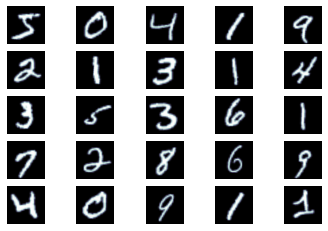

In [7]:
N_IMAGES = 25
images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]] 
plot_images(images)

In [8]:
VALID_RATIO = 0.9
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [9]:
train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

In [12]:
BATCH_SIZE = 64
train_iterator = data.DataLoader(train_data, shuffle = True, batch_size = BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size = BATCH_SIZE)

**Resnet Model**

In [22]:
model = models.resnet18(pretrained = False)

In [23]:
model.conv1.in_channels = 1
model.conv1.state_dict = 1
IN_CHANNELS = model.conv1.in_channels
conv1 = nn.Conv1d(1, 64, kernel_size = (7,7), stride = (2,2), padding = (3,3), bias = False)
model.conv1 = conv1

In [24]:
print(model)

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
OUTPUT_DIM = 10
IN_FEATURES = model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [26]:
model.fc = fc

In [29]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,175,370 trainable parameters


In [30]:
optimizer = optim.Adam(model.parameters())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [34]:
EPOCHS = 5
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
MAX_LRS = [p['lr'] for p in optimizer.param_groups]
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr = MAX_LRS, total_steps = TOTAL_STEPS)

In [35]:
def calculate_topk_accuracy(y_pred, y, k = 5):
  with torch.no_grad():
    batch_size = y.shape[0]
    _, top_pred = y_pred.topk(k, 1)
    top_pred = top_pred.t()
    correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
    correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
    correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
    acc_1 = correct_1 / batch_size
    acc_k = correct_k / batch_size
  return acc_1, acc_k

In [36]:
def train(model, iterator, optimizer, criterion, scheduler, device):
  epoch_loss = 0
  epoch_acc_1 = 0
  epoch_acc_5 = 0
  model.train()
  for (x, y) in iterator:
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    y_pred, _ = model(x)
    loss = criterion(y_pred, y)
    acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    epoch_loss += loss.item()
    epoch_acc_1 += acc_1.item()
    epoch_acc_5 += acc_5.item()
  epoch_loss /= len(iterator)
  epoch_acc_1 /= len(iterator)
  epoch_acc_5 /= len(iterator)
  return epoch_loss, epoch_acc_1, epoch_acc_5

In [37]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc_1 = 0
  epoch_acc_5 = 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      loss = criterion(y_pred, y)
      acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
      epoch_loss += loss.item()
      epoch_acc_1 += acc_1.item()
      epoch_acc_5 += acc_5.item()
  epoch_loss /= len(iterator)
  epoch_acc_1 /= len(iterator)
  epoch_acc_5 /= len(iterator)
  return epoch_loss, epoch_acc_1, epoch_acc_5

In [38]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [39]:
best_valid_loss = float('inf')
train_graph = {}
train_graph['Epoch'] = []
train_graph['Train_loss'] = []
train_graph['Train_Accuracy@1'] = []
train_graph['Train_Accuracy@5'] = []
train_graph['Valid_loss'] = []
train_graph['Valid_Accuracy@1'] = []
train_graph['Valid_Accuracy@5'] = []
for epoch in range(EPOCHS):
  start_time = time.monotonic()
  train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
  valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'tut1-model.pt')
  end_time = time.monotonic()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  train_graph['Epoch'].append(epoch+1)
  train_graph['Train_loss'].append(train_loss)
  train_graph['Train_Accuracy@1'].append(train_acc_1)
  train_graph['Train_Accuracy@5'].append(train_acc_5)
  train_graph['Valid_loss'].append(valid_loss)
  train_graph['Valid_Accuracy@1'].append(valid_acc_1)
  train_graph['Valid_Accuracy@5'].append(valid_acc_5)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
        f'Train Acc @5: {train_acc_5*100:6.2f}%')
  print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
        f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 3m 58s
	Train Loss: 0.531 | Train Acc @1:  85.61% | Train Acc @5:  97.11%
	Valid Loss: 0.196 | Valid Acc @1:  93.53% | Valid Acc @5:  99.97%
Epoch: 02 | Epoch Time: 4m 7s
	Train Loss: 0.052 | Train Acc @1:  98.42% | Train Acc @5:  99.98%
	Valid Loss: 0.030 | Valid Acc @1:  99.04% | Valid Acc @5:  99.98%
Epoch: 03 | Epoch Time: 4m 8s
	Train Loss: 0.029 | Train Acc @1:  99.11% | Train Acc @5: 100.00%
	Valid Loss: 0.030 | Valid Acc @1:  99.15% | Valid Acc @5:  99.98%
Epoch: 04 | Epoch Time: 4m 7s
	Train Loss: 0.013 | Train Acc @1:  99.60% | Train Acc @5: 100.00%
	Valid Loss: 0.017 | Valid Acc @1:  99.48% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 4m 7s
	Train Loss: 0.006 | Train Acc @1:  99.84% | Train Acc @5: 100.00%
	Valid Loss: 0.014 | Valid Acc @1:  99.63% | Valid Acc @5: 100.00%


In [40]:
model.load_state_dict(torch.load('tut1-model.pt'))
test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

Test Loss: 0.013 | Test Acc @1:  99.53% | Test Acc @5: 100.00%


In [41]:
def show_hist(x, y, x_label, y_label, axis_label='loss'):
  fig = plt.figure(figsize=(8,6))
  plt.plot(range(1,len(train_hist['Epoch'])+1),train_hist[x], label= x_label)
  plt.plot(range(1,len(train_hist['Epoch'])+1),train_hist[y],label= y_label)
  plt.xlabel('epochs')
  plt.ylabel(axis_label)
  plt.legend()
  plt.tight_layout()
  plt.show()

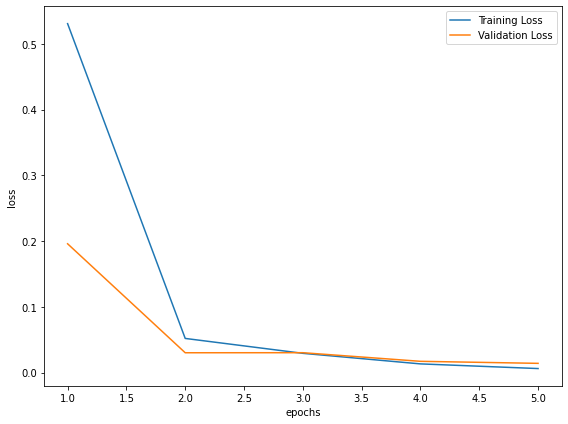

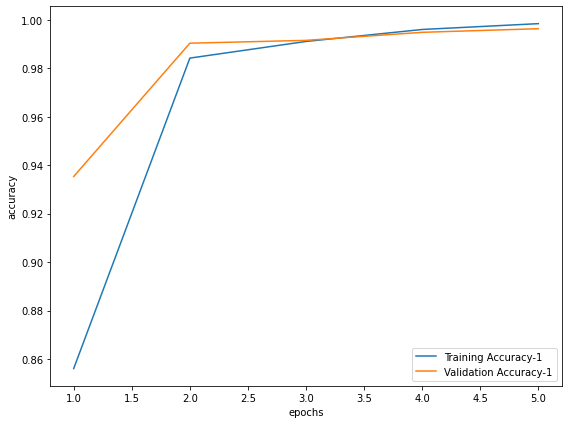

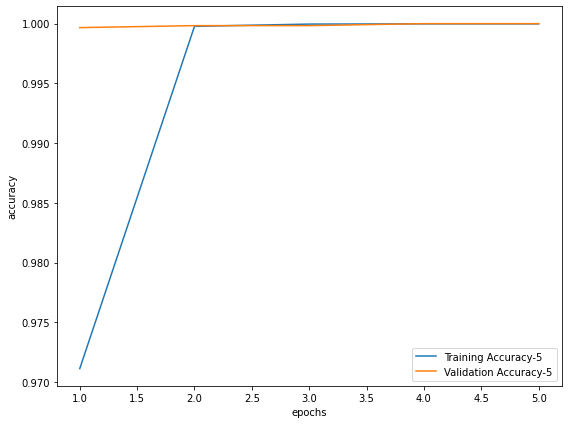

In [42]:
show_hist('Train_loss', 'Valid_loss', 'Training Loss', 'Validation Loss', 'loss')
show_hist('Train_Accuracy@1', 'Valid_Accuracy@1', 'Training Accuracy-1', 'Validation Accuracy-1', 'accuracy')
show_hist('Train_Accuracy@5', 'Valid_Accuracy@5', 'Training Accuracy-5', 'Validation Accuracy-5', 'accuracy')